In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plotter import *
from enum import Enum

G = 6.67430e-11  # gravitational constant
AU = 1.496e+11 # astronomical unit, m
SM = 1.989e30 # solar mass, kg
EM = 5.972e24 # earth mass, kg

In [2]:
class Body:
    def __init__(self, position, mass, velocity=None, name=""):
        self.name = name
        self.mass = mass
        self.position = np.array(position)
        if velocity is None:
            self.velocity = np.array([0.0, 0.0, 0.0])
        else:
            self.velocity = np.array(velocity)
            
    def __str__(self):  # for debugging
        x, y, z = self.position
        vx, vy, vz = self.velocity if self.velocity is not None else (0,0,0)
        data = f"m = {self.mass}\t x = ({x}, {y}, {z})\t v = ({vx}, {vy}, {vz})"
        if len(self.name) > 0:
            data = f"{self.name}: {data}"
        return data

In [3]:
# Force calculator class with two children: brute force and Barnes-Hut
class ForceCalculator:
    def compute_accelerations(self, positions, masses):
        pass
    
# Naively compute all O(n^2) force pairs
class DirectForceCalculator(ForceCalculator):
    def compute_accelerations(positions, masses):
        N = len(positions)
        accelerations = np.zeros((N, 3))

        for i in range(N):
            for j in range(N):
                if i == j:
                    continue
                r = positions[j] - positions[i]
                a = (G * masses[j] / np.linalg.norm(r)**3) * r
                accelerations[i] += a
        return accelerations

In [14]:
# Credit: https://www.cs.princeton.edu/courses/archive/fall03/cs126/assignments/barnes-hut.html
class OctDir(Enum):
    LNW = 0  # lower northwest
    LNE = 1
    LSW = 2
    LSE = 3
    UNW = 4
    UNE = 5
    USW = 6
    USE = 7
    
    def to_dx(self):
        dx = 1 if self.value % 2 == 1 else 0
        dy = 1 if (self.value % 4) < 2 else 0
        dz = 1 if self.value >= 4 else 0
        return np.array([dx, dy, dz])

class Octant:
    def __init__(self, endpoint, length):
        self.endpoint = endpoint  # lower bottom left point
        self.length = length
        
    def __str__(self):  # for debugging
        x,y,z = self.endpoint
        l = self.length
        return f"Octant of length {l} at ({x}, {y}, {z})"

    # Test if the vector x is contained within this octant
    def contains(self, x):
        dx = x - self.endpoint
        return ((dx >= 0) & (dx <= self.length)).all()
    
    # Returns a octant object for the given sub-octant enum
    def subOct(self, subOct):
        newLen = self.length / 2
        newEnd = self.endpoint + subOct.to_dx() * newLen
        return Octant(newEnd, newLen)
    
class BHNode():
    def __init__(self, octant):
        self.body = None  # is either a single body or a center of mass
        self.children = None
        self.octant = octant
      
    # for debugging: return total nonempty nodes (octants)
    def count(self):
        if self.body is None:
            return 0
        print(str(self.body))
        if self.children is None:
            return 1
        
        tot = 1
        for child in self.children:
            tot += child.count()
        return tot
    
    # Test if this body is in the given octant
    def contains_point(self, x):
        return self.octant.contains(x)
    
    # Add a child node
    def insert(self, position, mass):
        b = Body(position, mass)
        if self.children is None:  # Leaf node
            if self.body is None:  # Empty octant: just add body
                self.body = b
                return
            
            # Add 8 sub-octants as children
            self.children = []
            for octant in OctDir:
                sub_octant = self.octant.subOct(octant)
                self.children.append(BHNode(sub_octant))
                
            # Add existing body to correct suboctant
            for child in self.children:
                if child.contains_point(self.body.position):
                    child.insert(self.body.position, self.body.mass)
                    break
        
        # Aggregate bodies
        totMass = self.body.mass + b.mass;
        CoM = (self.body.mass * self.body.position + b.mass * b.position) / totMass
        self.body.mass = totMass
        self.body.position = CoM

        # Insert into appropriate child node
        for child in self.children:
            if child.contains_point(position):
                child.insert(position, mass)
                break
    
    # Compute the total force experienced by a body with the given position and mass
    def compute_force(self, position, mass, theta):
        if self.body is None:  # empty octant
            return 0
        
        s = self.octant.length
        r = self.body.position - position
        d = np.linalg.norm(r)
        if self.children is None and d < 1e-6:  # no self-interaction
            return 0
        
        d = max(1e-6, d)
        if self.children is None or s/d < theta:
            return (G * mass * self.body.mass / d**3) * r
        
        force = 0
        for child in self.children:
            force += child.compute_force(position, mass, theta)
        return force
        
class BarnesHutForceCalculator(ForceCalculator):
    def compute_accelerations(positions, masses):
        theta = 0.5
        N = len(positions)
        
        # Build root octant (i.e. the largest one)
        mins = np.min(positions, axis=0)
        maxes = np.max(positions, axis=0)
        length = max(maxes - mins)
        
        # Apply some padding to avoid weird floating point/boundary issues
        pad = length * 1e-6
        octant = Octant(mins - pad/2, length + pad)
        
        # Construct octree
        root = BHNode(octant)
        for i in range(N):
            root.insert(positions[i], masses[i])
        
        # Compute forces on each body
        accelerations = np.zeros((N, 3))
        for i in range(N):
            F = root.compute_force(positions[i], masses[i], theta)
            accelerations[i] = F / masses[i]
        return accelerations

In [5]:
class FastMultipoleForceCalculator(ForceCalculator):
    def compute_accelerations(positions, masses):
        return 0

In [6]:
# Integrator class with two children, RK4 and Leapfrog (symplectic)
class Integrator():
    def _derivatives(self, positions, vels):
        accs = self.force_calculator.compute_accelerations(positions, self.masses)
        return vels, accs

    def __init__(self, bodies, force_calculator):
        self.bodies = bodies
        self.masses = np.array([b.mass for b in bodies])
        self.force_calculator = force_calculator
        
    def get_state(self):
        positions = np.array([b.position for b in self.bodies])
        velocities = np.array([b.velocity for b in self.bodies])
        return positions, velocities

    def set_state(self, positions, velocities):
        for i, body in enumerate(self.bodies):
            body.position = positions[i]
            body.velocity = velocities[i]
    
class RK4Integrator(Integrator):
    def step(self, dt):
        p0, v0 = self.get_state()
        
        k1v, k1a = self._derivatives(p0, v0)
        k2v, k2a = self._derivatives(p0 + 0.5 * dt * k1v, v0 + 0.5 * dt * k1a)
        k3v, k3a = self._derivatives(p0 + 0.5 * dt * k2v, v0 + 0.5 * dt * k2a)
        k4v, k4a = self._derivatives(p0 + dt * k3v, v0 + dt * k3a)

        new_pos = p0 + (dt/6)*(k1v + 2*k2v + 2*k3v + k4v)
        new_vel = v0 + (dt/6)*(k1a + 2*k2a + 2*k3a + k4a)
        self.set_state(new_pos, new_vel)

class LeapfrogIntegrator(Integrator):
    def __init__(self, bodies, force_calculator):
        self.bodies = bodies
        self.masses = np.array([b.mass for b in bodies])
        self.force_calculator = force_calculator
        
        # Special for leapfrog!
        self.prev_acc = np.zeros((len(bodies), 3))
    
    def step(self, dt):
        p0, v0 = self.get_state()
        
        a0 = self.prev_acc
        a1 = self._derivatives(p0, v0)[1]

        p1 = p0 + (v0 * dt) + 0.5 * (a0 * dt**2)
        v1 = v0 + 0.5 * (a0 + a1) * dt

        self.set_state(p1, v1)
        self.prev_acc = a1

In [7]:
# simulation
class NBodySimulation:
    def __init__(self, bodies, Integrator, ForceCalculator):
        self.integrator = Integrator(bodies, ForceCalculator)
        
    def plot():
        return 0

    def run(self, dt, steps):
        # position history
        num_bodies = len(self.integrator.bodies)
        pos_hist = np.zeros((steps, num_bodies, 3))
        
        for i in range(steps):
            self.integrator.step(dt)
            for j, body in enumerate(self.integrator.bodies):
                pos_hist[i][j] = body.position
                
        return pos_hist

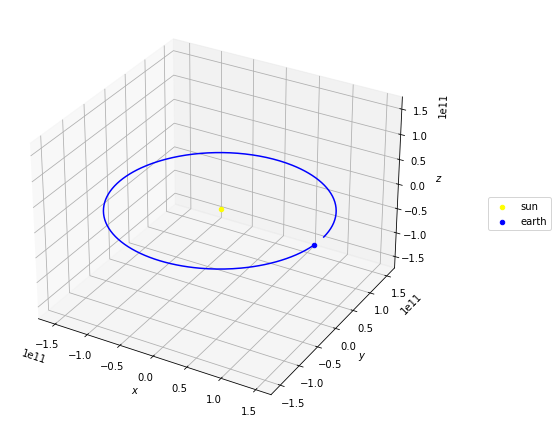

In [16]:
p1 = Body([0., 0., 0.], SM, [0., 0., 0.], "Sun")
p2 = Body([AU, 0., 0.], 5.972e24, [0., 30000., 0.], "Earth")
p3 = Body([15e8, 0., 14e6], 5.972e27, [100., 200., 300.], "Searth")
pluto = Body([39.5*AU, 0., 0.], 1.31e22, [0., 4740., 0.], "Pearth")

sim = NBodySimulation([p1, p2], RK4Integrator, BarnesHutForceCalculator)
day = 60*60*24

soln = sim.run(day, 365)
plot_3d_trajectory(soln, 10, 10, ['sun', 'earth'], ['yellow', 'blue'], True)

31.479614973068237


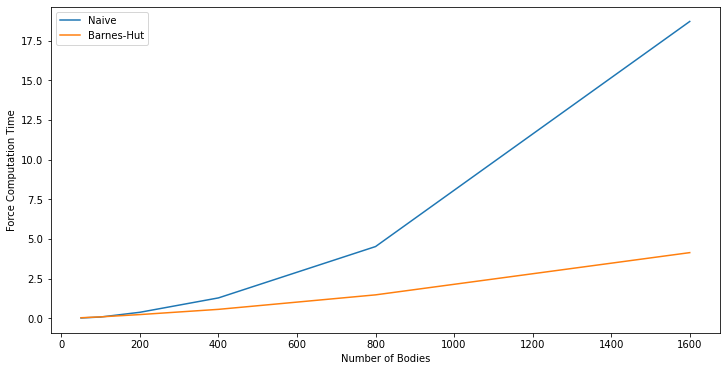

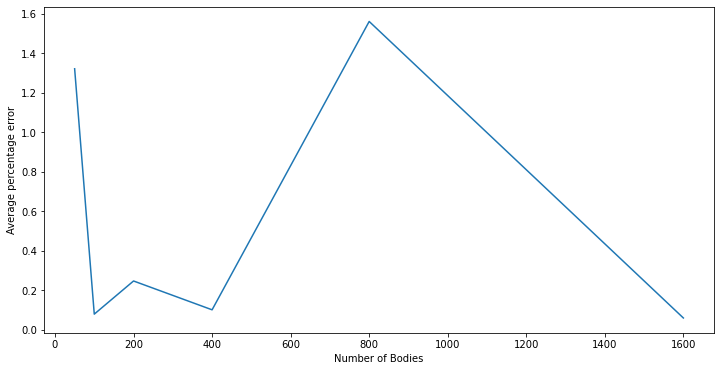

In [39]:
from time import time

direct_time = []
BH_time = []
err = []

Ns = [50, 100, 200, 400, 800, 1600]
start_t = time()
positions = []
masses = []

for N in Ns:
    while len(positions) < N:
        p = 0.5 * (np.random.rand(3) * AU + AU)
        mass = 0.5 * (np.random.rand() * SM + SM)
        positions.append(p)
        masses.append(mass)
        
    t0 = time()
    F_exact = DirectForceCalculator.compute_accelerations(positions, masses)
    t1 = time()
    F_approx = BarnesHutForceCalculator.compute_accelerations(positions, masses)
    t2 = time()
    
    direct_time.append(t1 - t0)
    BH_time.append(t2 - t1)
    pct_error = np.abs(F_exact - F_approx) / np.abs(F_exact)
    err.append(np.sum(pct_error) / N)
end_t = time()

print(end_t - start_t)

fig, ax = plt.subplots(1, 1, figsize=(12,6))
plt.plot(Ns, direct_time, label="Naive")
plt.plot(Ns, BH_time, label="Barnes-Hut")
plt.xlabel("Number of Bodies")
plt.ylabel("Force Computation Time")
ax.legend()
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(12,6))
plt.plot(Ns, err)
plt.xlabel("Number of Bodies")
plt.ylabel("Average percentage error")
plt.show()